In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('model.csv')

In [3]:
df.head()

,Unnamed: 0,sim_content,sin_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,comment_duplication,classifier_val
0,0,0.265999,-0.885466,1.402002,0.000000,1,3.142169,0.0,0,0.0,19.075011,1.0,0,0,0,0.0,0
1,1,0.327123,-0.922096,2.768422,0.000000,1,4.917200,0.0,0,0.0,19.075011,0.0,0,0,0,0.0,0
2,2,0.433972,-0.746774,3.531449,0.032258,1,5.735184,0.0,0,0.0,19.075011,4.0,0,0,0,0.0,0
3,3,0.201993,-1.008426,1.818057,0.000000,1,3.777639,0.0,0,0.0,19.075011,0.0,0,0,0,0.0,1
4,4,0.176263,-1.131799,1.402002,0.000000,1,3.015984,0.0,0,0.0,19.075011,0.0,0,0,0,0.0,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sin_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'comment_duplication', 'classifier_val'],
      dtype='object')

#### Standerdization is not required for naive bayes classifier

In [5]:
dfc = df.copy()

In [6]:
y = dfc['classifier_val']
X = dfc.drop(['classifier_val','id'],axis=1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Handle imbalnce dataset

In [8]:
dfc['classifier_val'].value_counts()

0    9831
1     804
Name: classifier_val, dtype: int64

In [9]:
from imblearn.combine import SMOTETomek
from collections import Counter

os=SMOTETomek(1)
X_train_os,y_train_os=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

X_train = X_train_os
y_train = y_train_os

C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


The number of classes before fit Counter({0: 6898, 1: 546})
The number of classes after fit Counter({0: 6868, 1: 6868})


### Hyperparameter Tuning

In [10]:
from sklearn.naive_bayes import GaussianNB

In [11]:
gnb = GaussianNB()

In [12]:
gnb.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [13]:
grid = {
    'priors': [None],
    'var_smoothing': [0.000001, 0.0000001, 0.00000001, 0.000000001, 0.00000001]
}

In [14]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True) 

In [15]:
from sklearn.model_selection import RandomizedSearchCV
gnb_random = RandomizedSearchCV(estimator=gnb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [16]:
gnb_random.fit(X_train,y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'priors': [None],
                                        'var_smoothing': [1e-06, 1e-07, 1e-08,
                                                          1e-09, 1e-08]},
                   return_train_score=True, scoring='accuracy', verbose=2)

### Evaluate

In [17]:
gnb_random.best_estimator_

GaussianNB(var_smoothing=1e-06)

In [18]:
gnb_random.best_score_

0.803438904384941

In [19]:
gnb_random.best_params_

{'var_smoothing': 1e-06, 'priors': None}

In [20]:
# To get the best model
best_model = gnb_random.best_estimator_

In [21]:
y_pred = best_model.predict(X_test)


In [22]:
err = (y_pred - y_test)


<AxesSubplot:>

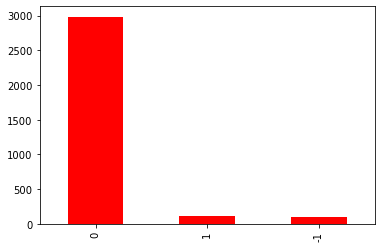

In [23]:
err.value_counts().plot(kind='bar',color='red')

In [24]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.06486994672516452
MSE: 0.06486994672516452
RMSE: 0.25469579251562935


In [25]:

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2819  114]
 [  93  165]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2933
           1       0.59      0.64      0.61       258

    accuracy                           0.94      3191
   macro avg       0.78      0.80      0.79      3191
weighted avg       0.94      0.94      0.94      3191



In [26]:
# for save the model if you want
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)

### ROC

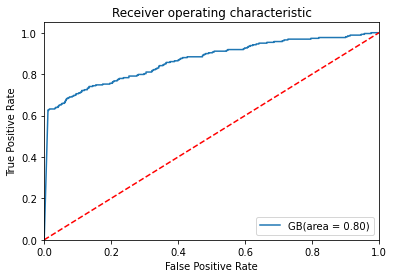

In [27]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

baseline_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fprB, tprB, thresholdsB = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fprB, tprB, label='GB(area = %0.2f)' % baseline_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()